In [23]:
import pickle
import os
import numpy as np
from scipy import signal
from scipy.stats import iqr,skew,kurtosis
import matplotlib.pyplot as plt
path = './temp/'
final_col = pickle.load(open('window_col_all_processed.p','rb'))
window_col = {}
count = 0
directories = ['acceptable/','unacceptable/','undecided/']
for i,a in enumerate(list(final_col.keys())):
    for window in final_col[a]:
        plt.figure()
        plt.plot(window[:,0]-window[0,0],window[:,1])
        plt.savefig(path+directories[i]+str(count)+'.pdf')
        window_col[count] = window
        count+=1
        plt.close('all')

pickle.dump(window_col,open('window_col_all1.p','wb'))

In [ ]:
import pickle
import os
import matplotlib.pyplot as plt
window_col = pickle.load(open('./data_saved/window_col_all1.p','rb'))
def get_keys(good,path):
    final_files = []
    for f in good:
        file_col = [int(a.split('.')[0]) for a in os.listdir(path+f)]
        final_files.extend(file_col)
    return final_files

keys = list(range(7000))
path = './temp/'
bad = ['unacceptable']
undecided = ['undecided']
good = ['acceptable']
good_files = get_keys(good,path)
bad_files = get_keys(bad,path)
# undecided_files = get_keys(undecided,path)
undecided_files =  list(set(keys).difference(set(good_files).union(set(bad_files))))
print(len(good_files),len(bad_files),len(undecided_files))
final_col = {'good':[],'bad':[],'undecided':[]}
label = list(final_col.keys())
final_path = './data_images_all/temp/'
directories = ['acceptable/','unacceptable/','undecided/']
import shutil
for a in directories:
    shutil.rmtree(final_path+a)
for i,a in enumerate([good_files,bad_files,undecided_files]):
    for f in a:
        window = window_col[f]
        plt.figure()
        plt.plot(window[:,0],window[:,1])
        plt.savefig(final_path+directories[i]+str(f)+'.pdf')
        plt.close('all')

In [32]:
import pickle
import os
window_col = pickle.load(open('window_col_all1.p','rb'))
def get_keys(good,path):
    final_files = []
    for f in good:
        file_col = [int(a.split('.')[0]) for a in os.listdir(path+f)]
        final_files.extend(file_col)
    return final_files

keys = list(range(7000))
path = './temp/'
bad = ['unacceptable']
undecided = ['undecided']
good = ['acceptable']
good_files = get_keys(good,path)
bad_files = get_keys(bad,path)
# undecided_files = get_keys(undecided,path)
undecided_files =  list(set(keys).difference(set(good_files).union(set(bad_files))))
print(len(good_files),len(bad_files),len(undecided_files))
final_col = {'good':[],'bad':[],'undecided':[]}
label = list(final_col.keys())
print(label)
for i,a in enumerate([good_files,bad_files,undecided_files]):
    for f in a:
        final_col[label[i]].append(window_col[f])

print(len(list(final_col.values())[0]),len(list(final_col.values())[1]),len(list(final_col.values())[2]))
pickle.dump(final_col,open('window_col_all_processed.p','wb'))

2307 1483 3210
['good', 'bad', 'undecided']
2307 1483 3210


In [1]:
import pickle
import os
import numpy as np
from scipy import signal
from scipy.stats import iqr,skew,kurtosis
import matplotlib.pyplot as plt
final_col = pickle.load(open('window_col_all_processed.p','rb'))
label = list(final_col.keys())
feature = np.zeros((0,5))
for i,k in enumerate(label):
    window_col = final_col[k]
    for window in window_col:
        f,pxx = signal.welch(window[:,1],fs=25,nperseg=len(window[:,1]),nfft=1000)
        pxx = np.abs(pxx)
        pxx = pxx/max(pxx)
        if i==1:
            temp = [skew(window[:,1]),kurtosis(window[:,1]),np.trapz(pxx[np.where((f>=.8)&(f<=2.5))[0]])/np.trapz(pxx),
                len(np.where(np.diff(np.signbit(window[:,1])))[0])/len(window[:,1]),-1]
        elif i==2:
            temp = [skew(window[:,1]),kurtosis(window[:,1]),np.trapz(pxx[np.where((f>=.8)&(f<=2.5))[0]])/np.trapz(pxx),
                len(np.where(np.diff(np.signbit(window[:,1])))[0])/len(window[:,1]),0]
        else:
            temp = [skew(window[:,1]),kurtosis(window[:,1]),np.trapz(pxx[np.where((f>=.8)&(f<=2.5))[0]])/np.trapz(pxx),
                len(np.where(np.diff(np.signbit(window[:,1])))[0])/len(window[:,1]),1]
        feature = np.concatenate((feature,np.array(temp).reshape(-1,5)))


pickle.dump(feature,open('window_col_all_processed_feature.p','wb'))

In [3]:
import pickle
import os
import numpy as np
from scipy import signal
from scipy.stats import iqr,skew,kurtosis
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier,RUSBoostClassifier
from sklearn.model_selection import GridSearchCV
from copy import deepcopy
from sklearn.model_selection import train_test_split
feature = pickle.load(open('window_col_all_processed_feature.p','rb'))
def get_metrics(feature,check):
    if check in ['good']:
        feature[np.where(feature[:,-1]==1)[0],-1] = 1
        feature[np.where(feature[:,-1]==-1)[0],-1] = -1
        feature[np.where(feature[:,-1]==0)[0],-1] = -1
#     else:
#         feature[np.where(feature[:,-1]==0)[0],-1] = -1
#         feature[np.where(feature[:,-1]==2)[0],-1] = -1
    param_grid = {"n_estimators":[50],
              "max_depth": [3, None],
              "max_features": [1],
              "min_samples_split": [2, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
#     clf = RandomForestClassifier()
    clf = BalancedRandomForestClassifier()
    cv = StratifiedKFold(n_splits=10)
    X_train, X_test, y_train, y_test = train_test_split(
    feature[:,:-1],feature[:,-1], test_size=0.33, random_state=44)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=list(cv.split(X_train,y_train)), iid=False,scoring='f1')
    grid_search.fit(X_train,y_train)
    y_pred = grid_search.predict(X_train)
#     y_pred = cross_val_predict(clf,X_train,y_train,cv=cv.split(X_train,y_train))
    print(classification_report(y_train,y_pred))
    print(confusion_matrix(y_train,y_pred))
#     clf.fit(X_train,y_train)
    y_pred_test = grid_search.predict(X_test)
    print(classification_report(y_test,y_pred_test))
    print(confusion_matrix(y_test,y_pred_test))
#     print(f1_score(y_true,y_pred),precision_score(y_true,y_pred),recall_score(y_true,y_pred),confusion_matrix(y_true,y_pred))
    pickle.dump(grid_search,open('classifier.p','wb'))

get_metrics(deepcopy(feature),'good')
# get_metrics(deepcopy(feature),'bad')

              precision    recall  f1-score   support

        -1.0       0.98      0.89      0.94      3136
         1.0       0.82      0.97      0.89      1554

    accuracy                           0.92      4690
   macro avg       0.90      0.93      0.91      4690
weighted avg       0.93      0.92      0.92      4690

[[2795  341]
 [  45 1509]]
              precision    recall  f1-score   support

        -1.0       0.92      0.83      0.88      1557
         1.0       0.71      0.85      0.78       753

    accuracy                           0.84      2310
   macro avg       0.82      0.84      0.83      2310
weighted avg       0.85      0.84      0.84      2310

[[1300  257]
 [ 110  643]]


In [37]:
import pandas as pd
df = pd.DataFrame(feature,columns=['Skewness','Kurtosis','Relative Power','Zero Crossing','Label'])
df['Label'][df['Label']==1] = 'Acceptable'
df['Label'][df['Label']==0] = 'Undecided'
df['Label'][df['Label']==-1] = 'Unacceptable'

In [39]:
import seaborn as sns

<IPython.core.display.Javascript object>


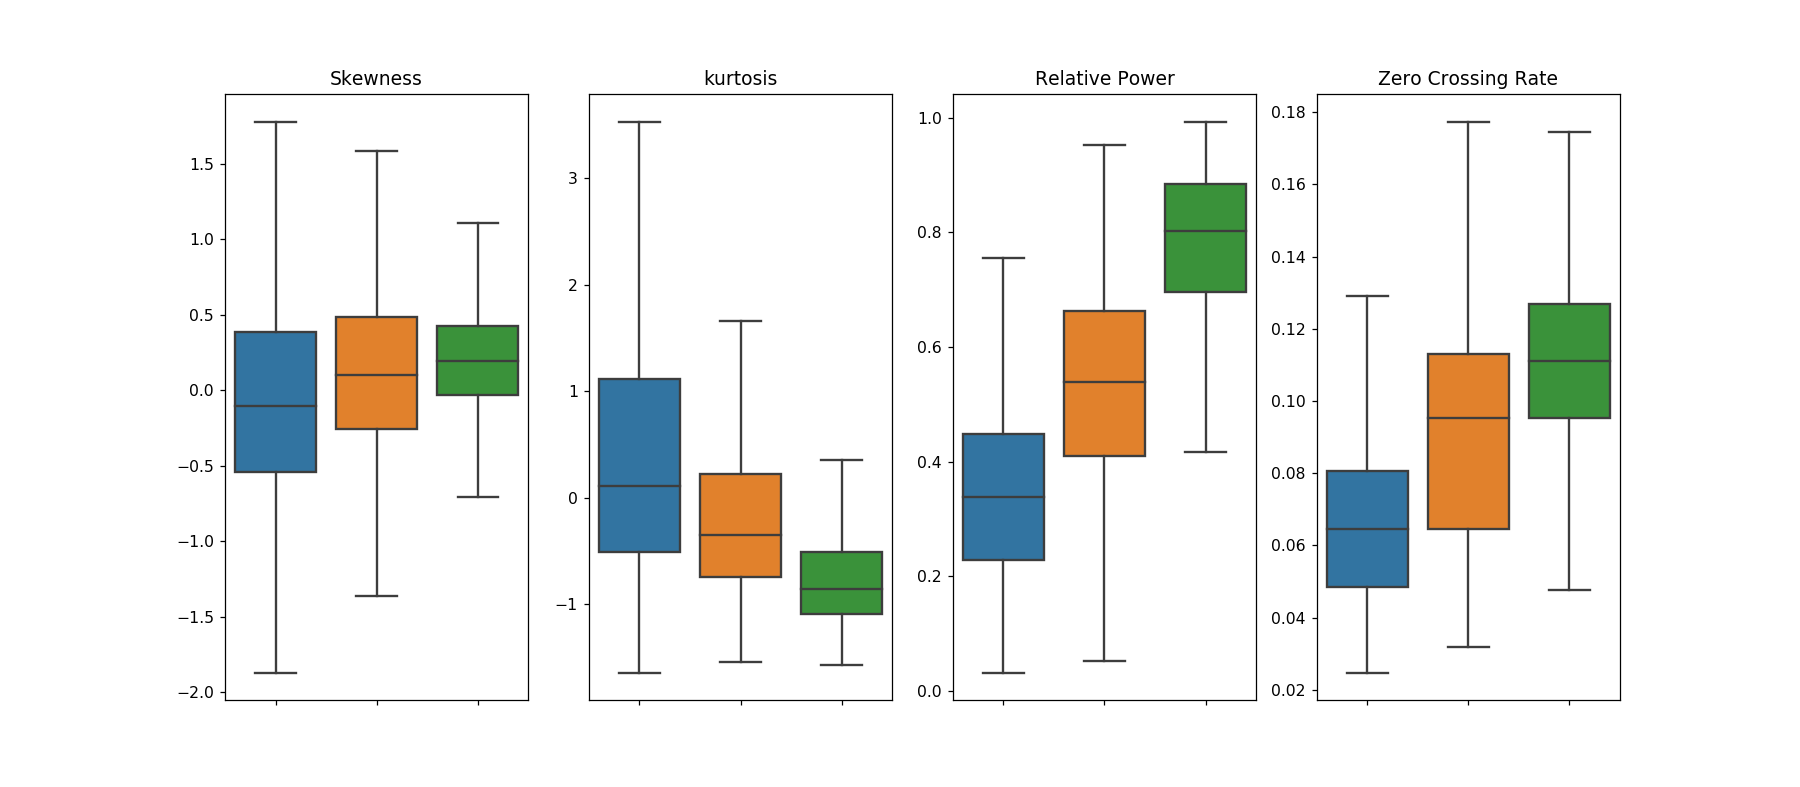

In [60]:
titles = ['Skewness','kurtosis','Relative Power','Zero Crossing Rate']
cl = ['c','y','b','g']
import seaborn as sns
fig,ax = plt.subplots(figsize=(16,7),nrows=1, ncols=4,sharex=False)
for i in range(0,4,1):
    sns.boxplot(y=feature[:,i],
                x=feature[:,-1], ax=ax[i],showfliers=False)
    plt.setp(ax[i],xticks=[0,1,2],
         xticklabels=[],title=titles[i])
#     ax[i].tick_params(axis='x', which='minor', labelsize='small', labelcolor='m', rotation=180)
# plt.xticks(rotation='vertical')
plt.savefig('inertial_distribution.png',dps=1000)
plt.show()

In [68]:
grid_search.best_model_


NameError: name 'grid_search' is not defined